In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', 500)
label_encoder = LabelEncoder()

housing_numeric = pd.read_pickle("housing_numeric.pkl")
housing_factor = pd.read_pickle("housing_factor.pkl")
housing_numeric['TotalSF'] = housing_numeric['TotalBsmtSF'] + housing_numeric['1stFlrSF'] + housing_numeric['2ndFlrSF']
housing_numeric['TotalBath'] = housing_numeric['BsmtFullBath'] + (housing_numeric['BsmtHalfBath']*0.5) + housing_numeric['FullBath'] + (housing_numeric['HalfBath']*0.5)
housing_factor['MixedExterior'] = housing_factor['Exterior1st'] + ' - ' + housing_factor['Exterior2nd']
housing_factor = housing_factor.apply(label_encoder.fit_transform)
housing_combined = pd.concat([housing_numeric, housing_factor], axis=1)
housing_combined = housing_combined.apply(label_encoder.fit_transform)
housing_combined  = housing_combined.drop(['PID', 'SalePrice'], axis=1)
housing_combined

,GrLivArea,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,GarageYrBlt,MoSold,YearBuilt,YearRemodAdd,TotalSF,TotalBath,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MixedExterior
1,70,45,459,0,120,0,519,251,189,0,0,2,0,1,0,2,1,2,1,3,145,0,0,0,0,51,0,0,4,29,2,44,0,162,3,6,5,1,1,3,3,0,0,0,21,2,2,0,2,6,5,1,0,13,14,2,3,4,1,5,5,3,5,6,1,4,1,3,4,6,2,5,3,5,5,1,3,4,1,9,4,73
2,197,18,134,108,367,133,64,404,362,0,0,2,0,2,0,2,1,3,0,1,48,0,93,0,0,0,0,0,3,74,1,87,34,381,5,0,5,1,1,3,3,0,4,0,7,2,2,4,2,5,4,1,0,6,6,1,2,4,1,2,5,2,2,0,1,4,1,3,2,6,3,1,0,5,5,1,3,4,1,9,4,24
3,160,36,237,0,514,0,61,234,319,0,0,0,0,1,0,2,1,3,0,1,21,109,0,16,1,0,0,0,1,20,10,36,57,225,0,6,1,1,1,3,3,0,4,0,11,2,2,0,2,5,8,3,0,8,8,2,2,4,0,5,5,3,0,6,1,0,1,3,2,6,3,5,3,5,4,0,3,4,1,9,4,35
4,188,57,511,0,0,0,336,26,87,24,0,0,0,1,0,2,1,4,0,1,57,0,0,93,0,16,0,0,3,30,4,11,53,76,0,11,5,1,1,3,3,0,0,0,20,2,2,0,5,4,7,1,0,8,8,2,2,2,0,1,5,3,6,6,1,2,1,3,4,6,3,5,3,5,5,0,3,4,1,9,4,35
5,704,47,563,0,437,0,119,211,152,340,0,2,0,2,1,3,1,4,0,3,261,0,35,0,0,0,0,0,3,91,10,104,51,621,6,10,5,1,1,3,3,0,4,0,17,2,2,0,5,8,5,1,0,12,13,2,2,4,2,2,5,3,2,6,1,0,1,3,2,6,3,1,0,5,5,1,3,4,1,9,4,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,132,45,663,0,0,0,760,322,273,0,0,0,0,1,0,2,1,2,1,1,10,0,86,0,0,1,0,0,3,7,4,22,0,258,0,6,5,1,1,3,3,0,4,0,3,2,2,0,1,6,5,1,0,13,14,2,3,4,0,5,5,3,6,6,3,1,0,1,1,6,2,5,3,1,4,1,3,4,1,9,4,73
760,756,45,1463,0,0,0,0,0,886,0,0,0,0,2,0,4,1,6,1,3,188,0,0,0,0,0,0,0,3,44,5,58,5,174,3,5,5,1,1,0,3,0,1,0,7,2,2,0,2,3,4,3,0,3,14,2,3,4,3,3,3,4,4,4,1,0,1,0,4,3,2,1,3,5,5,1,3,4,1,9,4,16
761,928,59,250,0,156,0,592,364,319,435,0,0,0,2,0,4,2,6,0,4,506,0,0,0,0,0,0,0,1,38,7,52,0,944,3,15,4,1,1,3,1,0,4,0,6,2,2,2,5,5,5,1,0,8,8,2,3,4,1,5,5,3,1,6,1,4,0,0,4,6,3,0,3,5,5,1,3,4,1,9,4,35
762,826,45,655,103,596,0,101,351,304,341,0,2,0,2,1,3,1,5,1,3,223,147,84,0,0,0,0,0,1,90,6,103,50,839,6,10,5,1,1,3,3,0,4,0,5,2,2,0,5,7,4,1,0,12,13,1,2,4,2,2,5,3,2,6,1,0,1,3,2,6,5,1,0,5,5,1,3,4,1,9,4,62


In [2]:
SalePrice = housing_numeric['SalePrice']

housing_refined = housing_combined[['MasVnrArea', 'BsmtQual', 'GarageArea', 'LotArea', 'GrLivArea', 'ExterQual', 
                           'BsmtFinSF1', 'LotFrontage', 'YearBuilt', 'Neighborhood', 'GarageType', 'OverallQual',
                           'TotRmsAbvGrd', 'YearRemodAdd', 'MSSubClass', 'OverallCond', 'BsmtExposure', 'TotalSF',
                           'TotalBath', 'MixedExterior', 'Fireplaces', 'KitchenQual', 'OpenPorchSF', 'WoodDeckSF', 'GarageYrBlt']].copy()

randomForest = ensemble.RandomForestRegressor(random_state=42) #random state is not necessary
grid_para_forest = { 
    'n_estimators': [50], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [None], 
    'max_leaf_nodes': [None] 
}
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring = 'r2', cv= 5, n_jobs = -1) #accuracy is default scoring method
%time grid_search_forest.fit(housing_refined, SalePrice) 

CPU times: total: 93.8 ms
Wall time: 3.9 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None], 'n_estimators': [50]},
             scoring='r2')

In [3]:
grid_search_forest.best_score_

0.9026028127706092

In [33]:
best_estimator = grid_search_forest.best_estimator_
feature_importance = pd.Series(best_estimator.feature_importances_, index= housing_refined.columns).sort_values(ascending=False).head(25)
feature_importance

TotalSF          0.219328
GrLivArea        0.122032
YearBuilt        0.081091
GarageArea       0.080880
BsmtQual         0.075575
OverallQual      0.065923
TotalBath        0.043505
BsmtFinSF1       0.038803
KitchenQual      0.036886
Fireplaces       0.030368
ExterQual        0.028869
GarageYrBlt      0.027339
LotArea          0.021519
MasVnrArea       0.020843
YearRemodAdd     0.017313
GarageType       0.013197
LotFrontage      0.011926
Neighborhood     0.011117
BsmtExposure     0.010892
OverallCond      0.009293
OpenPorchSF      0.008836
WoodDeckSF       0.007120
TotRmsAbvGrd     0.006672
MSSubClass       0.005831
MixedExterior    0.004843
dtype: float64

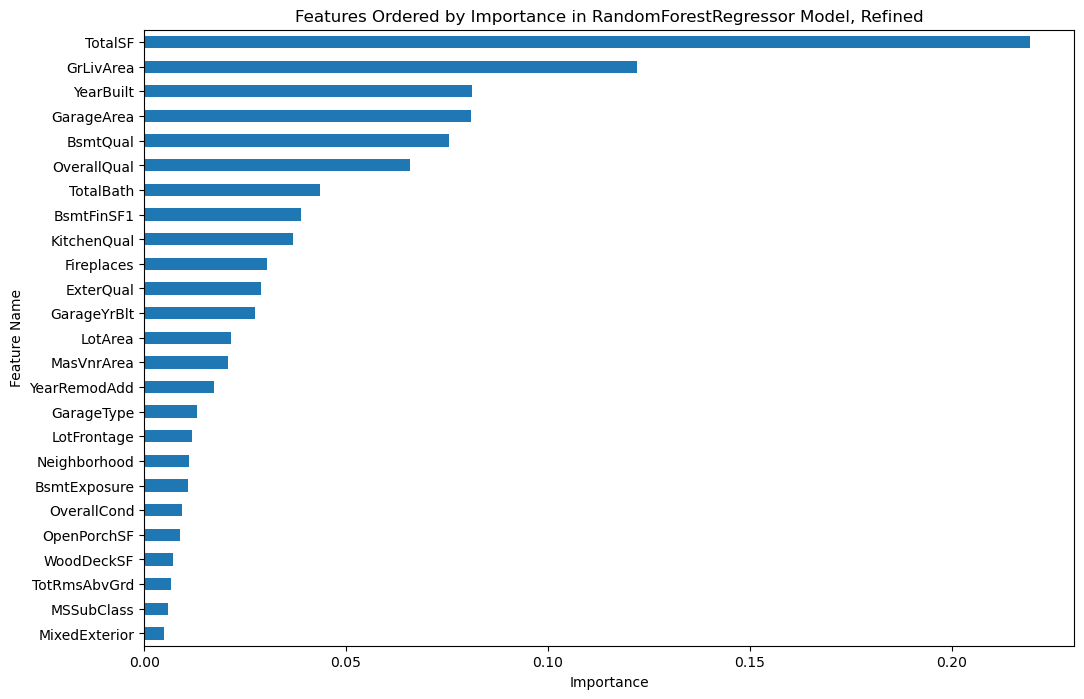

In [34]:
plt.figure(figsize=(12, 8))
feature_importance.plot(kind='barh')
plt.title(f'Features Ordered by Importance in RandomForestRegressor Model, Refined')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis() 

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing_refined, SalePrice, test_size=0.2, random_state=42)

In [6]:
def get_error(X_train, y_train, X_test, y_test, model, show = True):
    model.fit(X_train, y_train)
    train_error = 1 - model.score(X_train, y_train)
    test_error  = 1 - model.score(X_test, y_test)
    if show:
        print("The training error is: %.5f" %train_error)
        print("The test error is: %.5f" %test_error)
    return [train_error, test_error]

In [7]:
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
get_error(X_train,y_train,X_test,y_test,tree_model)

The training error is: 0.00097
The test error is: 0.98256


[0.0009689922480620172, 0.9825581395348837]

In [11]:
grid_para_tree = [
    {
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [None], 
    'max_leaf_nodes': [None] 
}
]

tree_model.set_params(random_state=0)
grid_search_tree = ms.GridSearchCV(tree_model, grid_para_tree, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)

grid_search_tree.fit(X_train, y_train)

C:\Users\immed\Programming\Anaconda\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=29, random_state=0),
             n_jobs=-1,
             param_grid=[{'max_depth': [None],
                          'max_features': ['sqrt', 'log2', None],
                          'max_leaf_nodes': [None]}],
             return_train_score=True, scoring='accuracy')

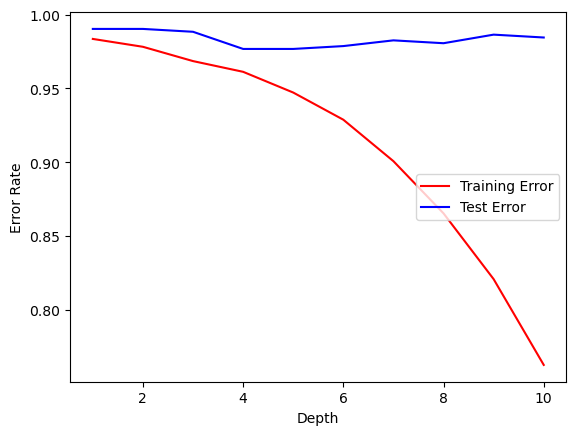

In [15]:
depth  = range(1, 11)
tree_train = []
tree_test = []
for i in depth:
    tree_model.set_params(max_depth = i)
    error = get_error(X_train, y_train, X_test, y_test, tree_model, show=False)
    tree_train.append(error[0])
    tree_test.append(error[1])


plt.plot(depth, tree_train, c = 'red', label='Training Error')
plt.plot(depth, tree_test, c = 'blue', label='Test Error')
plt.xlabel('Depth')
plt.ylabel('Error Rate')
plt.legend(loc=7)